# Graph Expressiveness Benchmark for ISP Testing

**Dataset artifact demo** — Standardizes graph expressiveness benchmark data for Interference-based Structural Probing (ISP) testing.

This notebook processes graph pair data from multiple benchmark sources (BREC NeurIPS 2023, CSL JMLR 2023) and converts each pair into a standardized schema with:
- **Input**: JSON-encoded edge lists and node degree sequences for graph pairs
- **Output**: Ground truth isomorphism labels (all pairs are non-isomorphic but WL-indistinguishable)
- **Metadata**: WL difficulty level, source benchmark, graph statistics

The benchmark contains 4 datasets across 3 difficulty levels:
- `brec_basic` (1-WL) — General graphs from BREC
- `brec_regular` (1-WL) — Strongly regular graphs from BREC
- `brec_cfi` (3-WL) — Combinatorial CFI constructions from BREC
- `csl` (1-WL) — 41-node 4-regular circular skip link graphs from HuggingFace

In [1]:
import subprocess, sys
def _pip(*a): subprocess.check_call([sys.executable, '-m', 'pip', 'install', '-q', *a])

# All packages used are pre-installed on Colab; install locally to match Colab env
if 'google.colab' not in sys.modules:
    _pip('numpy==2.0.2', 'matplotlib==3.10.0', 'networkx==3.6.1')


[notice] A new release of pip is available: 25.0.1 -> 26.0.1
[notice] To update, run: python3.12 -m pip install --upgrade pip


In [2]:
import json
import sys
from collections import Counter

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import networkx as nx
import numpy as np

## Load Data

Load the mini demo dataset from GitHub (with local fallback).

In [3]:
GITHUB_DATA_URL = "https://raw.githubusercontent.com/AMGrobelnik/ai-invention-1a90b0-interference-based-structural-probing-br/main/dataset_iter1_graph_expressiv/demo/mini_demo_data.json"
import json, os

def load_data():
    try:
        import urllib.request
        with urllib.request.urlopen(GITHUB_DATA_URL) as response:
            return json.loads(response.read().decode())
    except Exception: pass
    if os.path.exists("mini_demo_data.json"):
        with open("mini_demo_data.json") as f: return json.load(f)
    raise FileNotFoundError("Could not load mini_demo_data.json")

In [4]:
data = load_data()
print(f"Loaded {data['metadata']['total_examples']} examples across {data['metadata']['total_datasets']} datasets")
print(f"Schema: {data['metadata']['schema']}")
for ds in data['datasets']:
    print(f"  {ds['dataset']}: {len(ds['examples'])} examples")

Loaded 8 examples across 4 datasets
Schema: exp_sel_data_out
  brec_basic: 2 examples
  brec_regular: 2 examples
  brec_cfi: 2 examples
  csl: 2 examples


## Configuration

Tunable parameters for the demo. These control which datasets to process and how many examples to use.

In [5]:
# ── Config ──────────────────────────────────────────────────────────
# Selected datasets for ISP testing (original: all 4)
SELECTED_DATASETS = {"brec_basic", "brec_regular", "brec_cfi", "csl"}

# Maximum examples per dataset (None = use all available)
MAX_EXAMPLES_PER_DATASET = None

# Dataset ordering by difficulty
DATASET_ORDER = ["brec_basic", "brec_regular", "brec_cfi", "csl"]

## Convert Graph Pairs to Schema Format

The core processing function: converts each raw graph pair into a standardized example with input (JSON-encoded graphs), output (isomorphism label), and metadata fields.

In [6]:
def pair_to_example(pair: dict) -> dict:
    """Convert a single graph pair to schema-conforming example."""
    # Build input: JSON string with both graphs
    input_data = {
        "graph_a": {
            "num_nodes": pair["graph_a"]["num_nodes"],
            "num_edges": pair["graph_a"]["num_edges"],
            "edge_list": pair["graph_a"]["edge_list"],
            "node_degrees": pair["graph_a"]["node_degrees"],
        },
        "graph_b": {
            "num_nodes": pair["graph_b"]["num_nodes"],
            "num_edges": pair["graph_b"]["num_edges"],
            "edge_list": pair["graph_b"]["edge_list"],
            "node_degrees": pair["graph_b"]["node_degrees"],
        },
    }

    # Build output: ground truth
    if pair.get("is_isomorphic", False):
        output_label = "isomorphic"
    else:
        output_label = "non_isomorphic"

    # Build example with metadata
    example = {
        "input": json.dumps(input_data, separators=(",", ":")),
        "output": output_label,
        "metadata_pair_id": pair.get("metadata_pair_id", pair.get("pair_id", -1)),
        "metadata_wl_level": pair.get("metadata_wl_level", pair.get("wl_level", "unknown")),
        "metadata_same_wl_color": pair.get("metadata_same_wl_color", pair.get("same_wl_color", False)),
        "metadata_source": pair.get("metadata_source", pair.get("source", "unknown")),
        "metadata_graph_a_nodes": pair["graph_a"]["num_nodes"],
        "metadata_graph_a_edges": pair["graph_a"]["num_edges"],
        "metadata_graph_b_nodes": pair["graph_b"]["num_nodes"],
        "metadata_graph_b_edges": pair["graph_b"]["num_edges"],
        "metadata_task_type": "classification",
        "metadata_n_classes": 2,
        "metadata_notes": pair.get("metadata_notes", pair.get("notes", "")),
    }

    return example

## Process Datasets

Group examples by dataset, filter to selected datasets, and re-encode each example through the standardization pipeline.

In [7]:
# ── Process each dataset: parse input JSON, re-encode through pair_to_example ──
datasets_dict: dict[str, list[dict]] = {}

for ds in data["datasets"]:
    ds_name = ds["dataset"]

    if ds_name not in SELECTED_DATASETS:
        continue

    examples = ds["examples"]
    if MAX_EXAMPLES_PER_DATASET is not None:
        examples = examples[:MAX_EXAMPLES_PER_DATASET]

    processed = []
    for ex in examples:
        # Parse the input JSON to get graph structures
        input_parsed = json.loads(ex["input"])

        # Build a pair dict that pair_to_example can process
        pair = {
            "graph_a": input_parsed["graph_a"],
            "graph_b": input_parsed["graph_b"],
            "is_isomorphic": ex["output"] == "isomorphic",
            "metadata_pair_id": ex["metadata_pair_id"],
            "metadata_wl_level": ex["metadata_wl_level"],
            "metadata_same_wl_color": ex["metadata_same_wl_color"],
            "metadata_source": ex["metadata_source"],
            "metadata_notes": ex["metadata_notes"],
        }

        processed_example = pair_to_example(pair)
        processed.append(processed_example)

    datasets_dict[ds_name] = processed
    print(f"  {ds_name}: {len(processed)} examples processed")

# ── Build output in schema format, ordered by difficulty ──
datasets_list = []
for ds_name in DATASET_ORDER:
    if ds_name in datasets_dict:
        datasets_list.append({
            "dataset": ds_name,
            "examples": datasets_dict[ds_name],
        })

output_data = {
    "metadata": {
        "description": "Graph expressiveness benchmark for ISP testing",
        "total_examples": sum(len(d["examples"]) for d in datasets_list),
        "total_datasets": len(datasets_list),
        "sources": data["metadata"]["sources"],
        "schema": "exp_sel_data_out",
    },
    "datasets": datasets_list,
}

print(f"\nTotal datasets: {output_data['metadata']['total_datasets']}")
print(f"Total examples: {output_data['metadata']['total_examples']}")

  brec_basic: 2 examples processed
  brec_regular: 2 examples processed
  brec_cfi: 2 examples processed
  csl: 2 examples processed

Total datasets: 4
Total examples: 8


## Results Summary

Print a summary table of the processed benchmark data showing dataset statistics and difficulty levels.

In [8]:
# ── Results summary table ──
print(f"{'Dataset':<15} {'Examples':>8} {'WL Level':>10} {'Source':>25} {'Nodes':>8} {'Edges':>8}")
print("-" * 78)
for ds in output_data["datasets"]:
    exs = ds["examples"]
    wl = exs[0]["metadata_wl_level"] if exs else "?"
    src = exs[0]["metadata_source"] if exs else "?"
    nodes = exs[0]["metadata_graph_a_nodes"] if exs else "?"
    edges = exs[0]["metadata_graph_a_edges"] if exs else "?"
    print(f"{ds['dataset']:<15} {len(exs):>8} {wl:>10} {src:>25} {nodes:>8} {edges:>8}")
print("-" * 78)
print(f"{'TOTAL':<15} {output_data['metadata']['total_examples']:>8}")

# Show a sample processed example
print("\n── Sample processed example (brec_basic) ──")
sample = output_data["datasets"][0]["examples"][0]
for key, val in sample.items():
    if key == "input":
        val_str = val[:80] + "..." if len(str(val)) > 80 else val
        print(f"  {key}: {val_str}")
    else:
        print(f"  {key}: {val}")

Dataset         Examples   WL Level                    Source    Nodes    Edges
------------------------------------------------------------------------------
brec_basic             2       1-WL                      BREC       10       26
brec_regular           2       1-WL                      BREC       10       38
brec_cfi               2       3-WL                      BREC       10       22
csl                    2       1-WL HuggingFace graphs-datasets/CSL       41       82
------------------------------------------------------------------------------
TOTAL                  8

── Sample processed example (brec_basic) ──
  input: {"graph_a":{"num_nodes":10,"num_edges":26,"edge_list":[[0,3],[0,5],[0,7],[0,8],[...
  output: non_isomorphic
  metadata_pair_id: 0
  metadata_wl_level: 1-WL
  metadata_same_wl_color: True
  metadata_source: BREC
  metadata_graph_a_nodes: 10
  metadata_graph_a_edges: 26
  metadata_graph_b_nodes: 10
  metadata_graph_b_edges: 26
  metadata_task_type: classif

## Visualization

Visualize the benchmark data: (1) a bar chart of examples per dataset with WL difficulty coloring, (2) graph structure comparison showing a non-isomorphic pair side-by-side, and (3) degree distribution comparison across datasets.

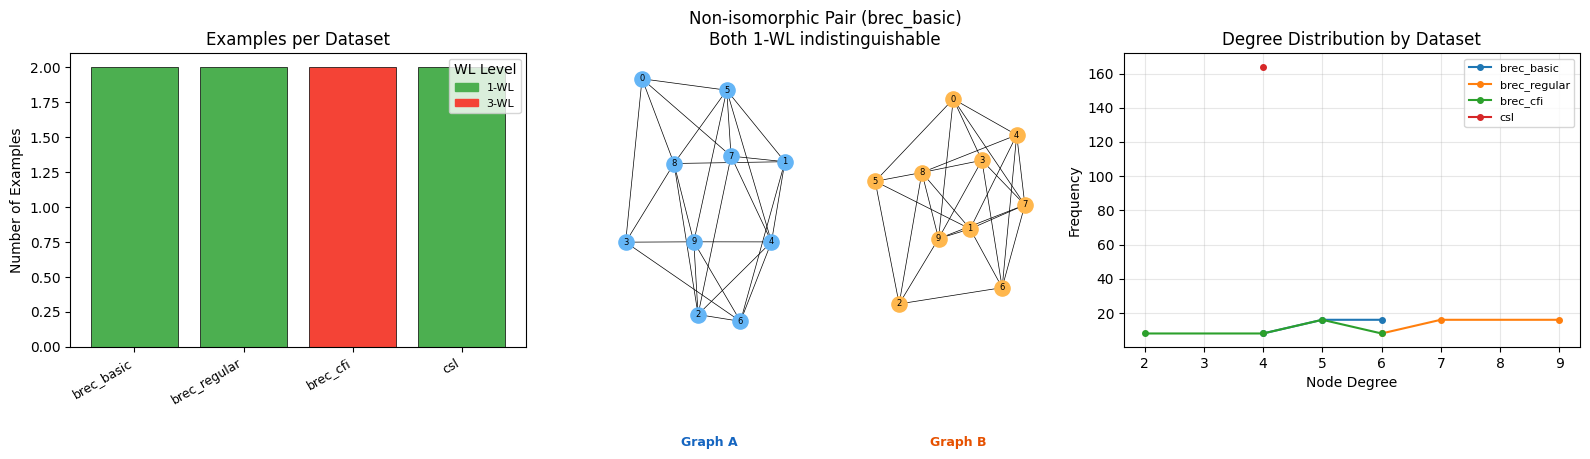

Visualization saved to benchmark_visualization.png


In [9]:
fig, axes = plt.subplots(1, 3, figsize=(16, 5))

# ── Plot 1: Examples per dataset with WL difficulty coloring ──
ax = axes[0]
ds_names = [ds["dataset"] for ds in output_data["datasets"]]
ds_counts = [len(ds["examples"]) for ds in output_data["datasets"]]
wl_levels = [ds["examples"][0]["metadata_wl_level"] for ds in output_data["datasets"]]
wl_colors = {"1-WL": "#4CAF50", "3-WL": "#F44336"}
bar_colors = [wl_colors.get(wl, "#999") for wl in wl_levels]
ax.bar(ds_names, ds_counts, color=bar_colors, edgecolor="black", linewidth=0.5)
ax.set_ylabel("Number of Examples")
ax.set_title("Examples per Dataset")
ax.tick_params(axis="x", rotation=30)
for label in ax.get_xticklabels():
    label.set_ha("right")
    label.set_fontsize(9)
patches = [mpatches.Patch(color=c, label=l) for l, c in wl_colors.items()]
ax.legend(handles=patches, title="WL Level", fontsize=8)

# ── Plot 2: Graph pair visualization (first brec_basic pair) ──
ax = axes[1]
sample_ex = output_data["datasets"][0]["examples"][0]
sample_input = json.loads(sample_ex["input"])
G_a = nx.Graph()
G_a.add_nodes_from(range(sample_input["graph_a"]["num_nodes"]))
G_a.add_edges_from(sample_input["graph_a"]["edge_list"])

G_b = nx.Graph()
G_b.add_nodes_from(range(sample_input["graph_b"]["num_nodes"]))
G_b.add_edges_from(sample_input["graph_b"]["edge_list"])

# Draw both graphs offset
pos_a = nx.spring_layout(G_a, seed=42)
pos_b = nx.spring_layout(G_b, seed=42)
# Offset graph B to the right
pos_b_offset = {k: (v[0] + 3.0, v[1]) for k, v in pos_b.items()}

nx.draw_networkx(G_a, pos_a, ax=ax, node_size=120, node_color="#64B5F6",
                 font_size=6, width=0.5, with_labels=True)
nx.draw_networkx(G_b, pos_b_offset, ax=ax, node_size=120, node_color="#FFB74D",
                 font_size=6, width=0.5, with_labels=True)
ax.set_title(f"Non-isomorphic Pair (brec_basic)\nBoth {sample_ex['metadata_wl_level']} indistinguishable")
ax.text(0.0, -1.8, "Graph A", ha="center", fontsize=9, color="#1565C0", fontweight="bold")
ax.text(3.0, -1.8, "Graph B", ha="center", fontsize=9, color="#E65100", fontweight="bold")
ax.axis("off")

# ── Plot 3: Degree distribution comparison across datasets ──
ax = axes[2]
for ds in output_data["datasets"]:
    all_degrees = []
    for ex in ds["examples"]:
        inp = json.loads(ex["input"])
        all_degrees.extend(inp["graph_a"]["node_degrees"])
        all_degrees.extend(inp["graph_b"]["node_degrees"])
    degree_counts = Counter(all_degrees)
    degrees_sorted = sorted(degree_counts.keys())
    counts_sorted = [degree_counts[d] for d in degrees_sorted]
    ax.plot(degrees_sorted, counts_sorted, marker="o", markersize=4, label=ds["dataset"], linewidth=1.5)

ax.set_xlabel("Node Degree")
ax.set_ylabel("Frequency")
ax.set_title("Degree Distribution by Dataset")
ax.legend(fontsize=8)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig("benchmark_visualization.png", dpi=150, bbox_inches="tight")
plt.show()
print("Visualization saved to benchmark_visualization.png")